In [1]:
import os
from collections import Counter

In [2]:
from pm4py.algo.discovery.dfg import factory as dfg_factory
from pm4py.objects.log.adapters.pandas import csv_import_adapter
from pm4py.algo.discovery.dfg.adapters.pandas import df_statistics
from pm4py import util as pmutil

from pandas import read_csv
file = read_csv(os.path.join("files","input_data","sepsis.csv"))

log = csv_import_adapter.convert_timestamp_columns_in_df(file, timest_columns=[
    'timestamp'
])

source_list=[]
sink_dict={}
source_cases=[]
for i, case_id in enumerate(log['case_id']):
    sink_dict[case_id]=log['activity'][i]
    if case_id not in source_cases:
        source_cases.append(case_id)
        source_list.append(log['activity'][i])
source_dict = Counter(source_list)
sink_dict = Counter(sink_dict.values())


dfg_frequency, dfg_performance = df_statistics.get_dfg_graph(log, measure="both",
                                                            activity_key='activity',
                                                            timestamp_key='timestamp',
                                                            case_id_glue='case_id')

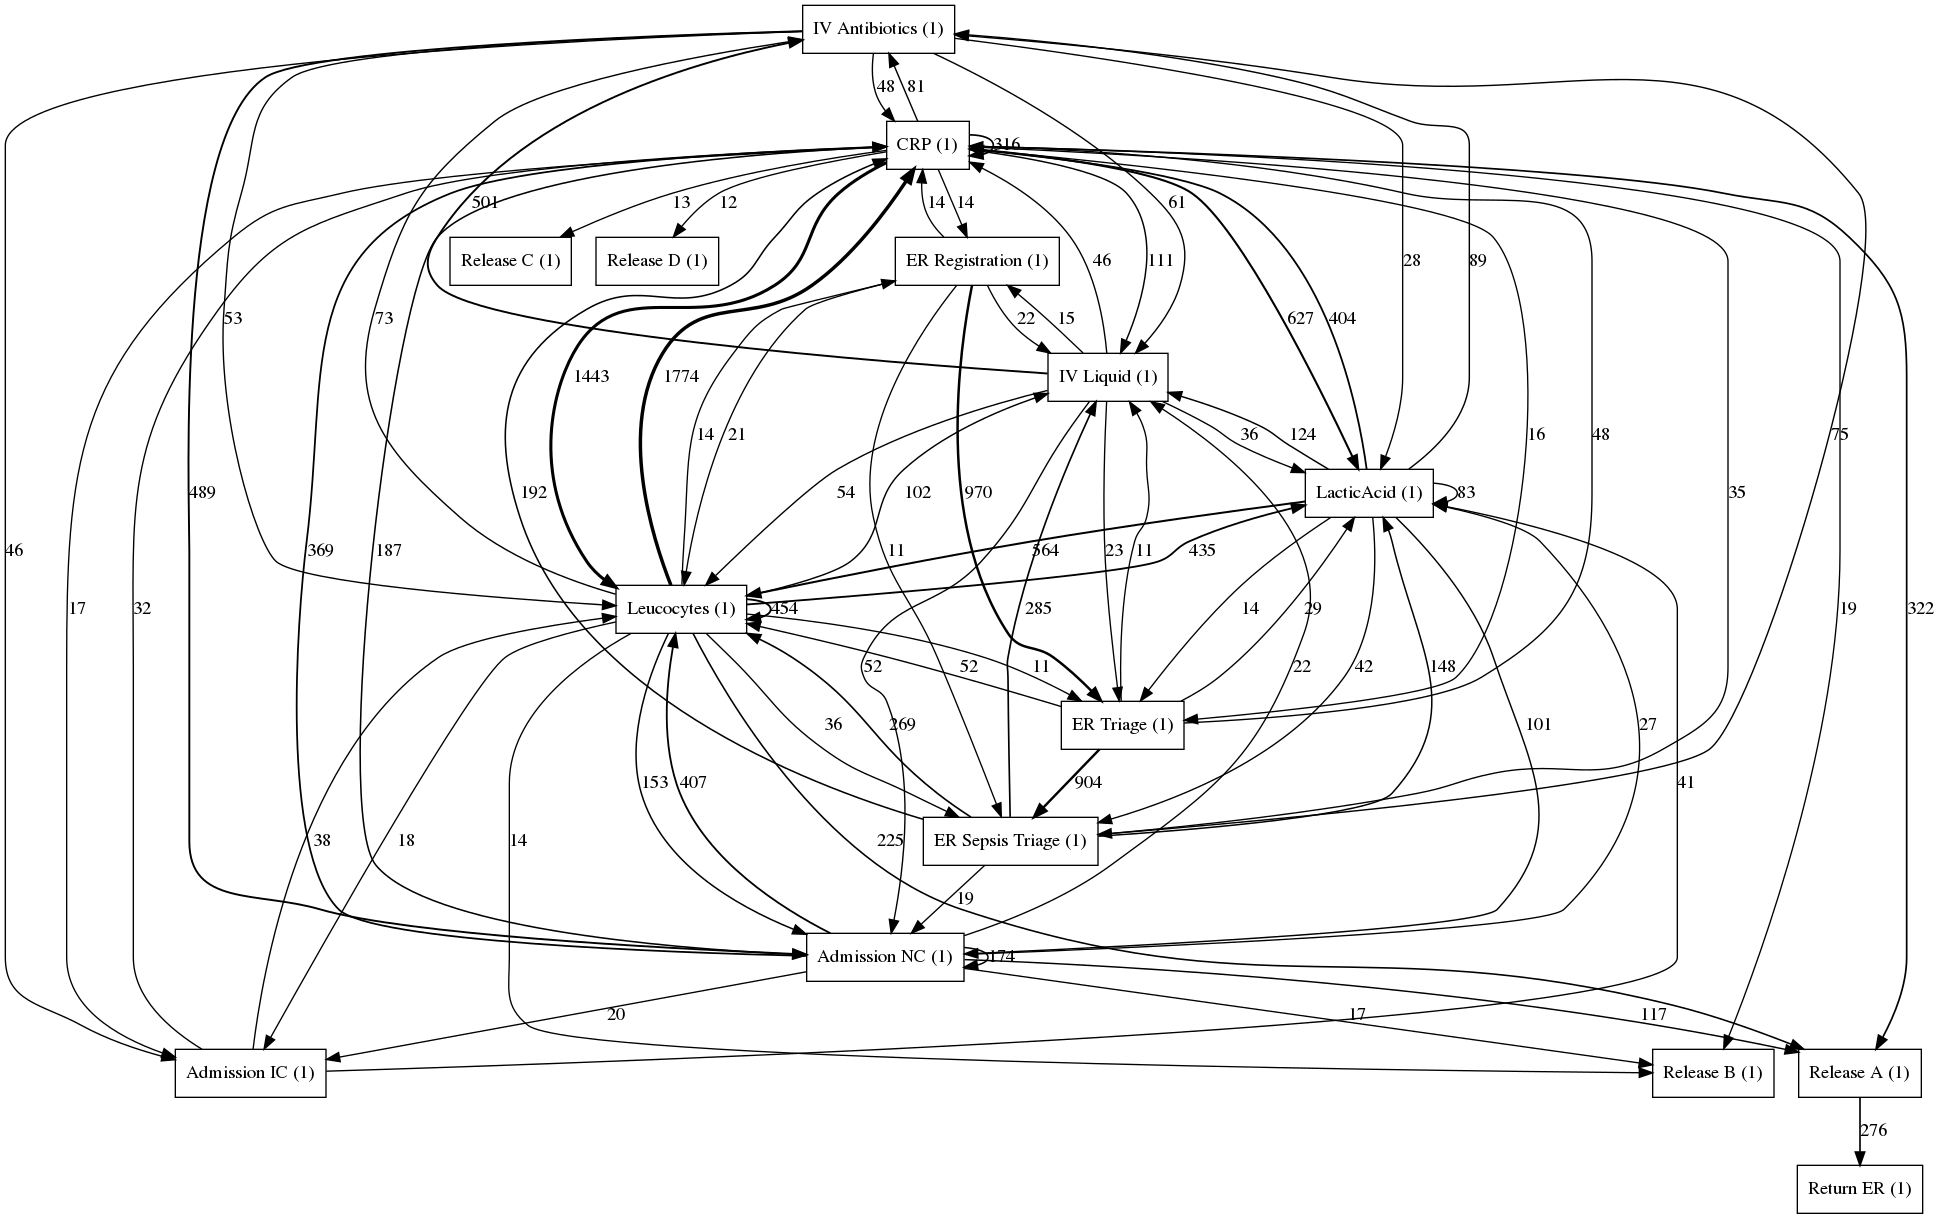

In [3]:
from pm4py.visualization.dfg import factory as dfg_vis_factory

gviz = dfg_vis_factory.apply(dfg_frequency, variant="frequency")
dfg_vis_factory.view(gviz)

In [4]:
from ntnu_process_mining import ProcessMap


activities = file.groupby('case_id').agg({'activity': lambda x: ''.join(x)}).groupby('activity')

process_map = ProcessMap()

def on_filter_change(change={}):
    filter_value=process_map.filter

    case_ids = activities.filter(lambda x: len(x) > filter_value).index
    
    filtered_log = log[log['case_id'].isin(case_ids)]
    dfg_frequency, dfg_performance = df_statistics.get_dfg_graph(filtered_log, measure="both",
                                                                activity_key='activity',
                                                                timestamp_key='timestamp',
                                                                case_id_glue='case_id')
    
    pm_edges = []
       
    #pm_edges.append({'from': 'start', 'to': dst, 'value': weight})
    # max_weight = max([freq for edge,freq in dfg_frequency.items()])
    sources = []
    destinations = []
    for (src, dst), weight in dfg_frequency.items():
        # if max_weight*(process_map.filter/100) <= weight:
        pm_edges.append({"from": src, "to": dst, "value": weight, "perf": round(dfg_performance[(src, dst)]/60, 0)})
        sources.append(src)
        destinations.append(dst)
        
    for key, value in source_dict.items():
        if key in sources:
            pm_edges.append({"from": "SOURCE", "to": key, "value": ""})
    for key, value in sink_dict.items():
        if key in destinations:
            pm_edges.append({"from": key, "to": "SINK", "value": ""})    
        
    process_map.value=pm_edges

process_map.observe(on_filter_change, names='filter')

on_filter_change()
process_map

ProcessMap()